<a href="https://colab.research.google.com/github/nerdk312/TF_2.0_Keras_VAE_CNN/blob/master/Caltech101_94x94_CNN_VAE_modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/chaitanya100100/VAE-for-Image-Generation/blob/master/src/cifar10_train.py

Code based on this implementation

In [0]:
!pip uninstall tensorflow
!pip install tensorflow-gpu
!pip install Pillow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 380.8MB 37kB/s 
     |████████████████████████████████| 450kB 50.3MB/s 
     |████████████████████████████████| 3.8MB 40.2MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 wh

In [0]:
import os
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
from keras.preprocessing import image as image_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Preprocessing

## Loading data from google drive

In [0]:
from google.colab import drive #  
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
target_size =  (94,94)

inp_dir = '/content/gdrive/My Drive/101_ObjectCategories'
classes = os.listdir(inp_dir)
all_images = []
all_labels = []

i = 0 
for idx, c in enumerate(classes):
  img_list = os.listdir(inp_dir + '/' + c)
  print(idx)
  j = 0 
  for img in img_list:
    fname = inp_dir + '/' + c+ '/' + img
    image = image_utils.load_img(fname).resize(target_size,Image.ANTIALIAS)
    image = np.array(image.getdata()).reshape(target_size[0], target_size[1], 3)
    image = image.astype('float32')/255
    all_images.append(image)
    all_labels.append(idx)
    
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(all_images.shape)
print(all_labels.shape)

np.save('full_x_94x94', all_images)
np.save('full_y_94x94', all_labels)                    

#x_train = np.load('/content/gdrive/My Drive/grayscale_train_180x160.npy')
#x_test = np.load('/content/gdrive/My Drive/grayscale_val_180x160 (1).npy')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
(9145, 128, 128, 3)
(9145,)


# Loading the dataset

In [0]:
x = np.load('full_x_94x94.npy')
y = np.load('full_y_94x94.npy')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1) # Nawid - Data has already been preprocessed so I do not need to divide by 255 
img_shape = x_train.shape
original_img_size = (img_shape[1],img_shape[2],img_shape[3]) # Nawid - Dimensions of the image

# Architecture -  VAE

In [0]:
# network parameters
img_rows, img_cols, img_chns = 94, 94, 3 # Nawid - Changed it from 94 to 92 as I input the incorrect size, may need to save the data again if the 92 has issue (which could happen due to convolutions)
latent_dim = 32
intermediate_dimension = 256
epsilon_std = 1.0
epochs = 500
num_filters = 32
num_conv = 3
batch_size = 256

In [0]:
class Sampling(tf.keras.layers.Layer): # Nawid - Specifies a custom layer
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0] # Nawid - Batch size
    dim = tf.shape(z_mean)[1] # Nawid -  Dimension of z
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Nawid - Initalised random values with a mean of 0 and a standard deviation of 1
    return z_mean + tf.exp(z_log_var) * epsilon # Nawid - Slightly different from the usually as the variance is not square rooted
    #return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#z = Sampling()((z_mean, z_log_sigma)) # Nawid - Instantiates the custom layer and gets the output of the custom layer which is the value of z

In [0]:
class Encoder(tf.keras.layers.Layer): # Nawid - This defines the layer for the encoder
  def __init__(self,latent_dim, intermediate_dim = intermediate_dimension):
    super(Encoder, self).__init__()
    self.Conv1 = tf.keras.layers.Conv2D(filters = img_chns, kernel_size = 3, activation ='relu', strides = 1, padding = 'same')
    self.Conv2 = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = 3, activation ='relu', strides = 2, padding = 'same')
    self.Conv3 = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = num_conv, activation ='relu', strides = 2, padding = 'same')
    self.Conv4 = tf.keras.layers.Conv2D(filters = num_conv, kernel_size = num_conv, activation ='relu', strides = 2, padding = 'same')
    self.Flatten  = tf.keras.layers.Flatten()

    self.Hidden = tf.keras.layers.Dense(intermediate_dim, activation='relu')
    self.Dense_mean = tf.keras.layers.Dense(latent_dim)
    self.Dense_log_var = tf.keras.layers.Dense(latent_dim)
    self.sampling = Sampling() # Nawid-  This instantiates the sampling layer for the encoder

  def call(self,inputs):
    x_conv = self.Conv1(inputs)
    x_conv = self.Conv2(x_conv)
    x_conv = self.Conv3(x_conv)
    x_conv = self.Conv4(x_conv)
    flat_x = self.Flatten(x_conv)

    hidden_x = self.Hidden(flat_x)
    z_mean = self.Dense_mean(hidden_x)
    z_log_var = self.Dense_log_var(hidden_x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean,z_log_var, z#, conv_shape # Nawid-  Need to output the z variables as well as the shape for the decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim = intermediate_dimension): # Nawid - Need to put the shape of post convolution into the parameters
    super(Decoder,self).__init__()
    
    self.Dense_intermediate = tf.keras.layers.Dense(intermediate_dim, activation='relu')
    self.Dense_upsample = tf.keras.layers.Dense(num_filters * 12 * 12, activation ='relu') # Nawid - Dense layer which increases the number of values 
    output_shape = (batch_size, 12, 12, num_filters)
    self.Reshape = tf.keras.layers.Reshape(output_shape[1:]) # Nawid - Used to reshape the output
    
    self.Conv_transpose1 = tf.keras.layers.Conv2DTranspose(filters= num_filters, kernel_size=num_conv, padding ='same', strides= 2, activation='relu')
    self.Conv_transpose2 = tf.keras.layers.Conv2DTranspose(filters= num_filters, kernel_size = num_conv, padding = 'same', strides =2, activation='relu')
    self.Conv_transpose3 = tf.keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=3, padding='same',strides=2, activation = 'relu')
    self.Conv = tf.keras.layers.Conv2D(filters = img_chns, kernel_size =3, padding='valid',strides = 1, activation='sigmoid')

  def call(self, inputs):
    x1 = self.Dense_intermediate(inputs)
    x1 = self.Dense_upsample(x1)
    x1_reshape = self.Reshape(x1)
    x1_deconv = self.Conv_transpose1(x1_reshape)
    x1_deconv = self.Conv_transpose2(x1_deconv)
    x1_deconv = self.Conv_transpose3(x1_deconv)
    x_reconstruct = self.Conv(x1_deconv)
    return x_reconstruct

In [0]:
x = tf.keras.layers.Input(shape=original_img_size)  # Nawid - Input layer
encoder = Encoder(latent_dim) # Nawid - Instantiates encoder layer which is required to find the shape property
z_mean, z_log_var, z = encoder(x)

encoder_model = tf.keras.Model(x,z)
encoder_model.summary()
  
output = Decoder()(z)
vae =tf.keras.Model(x, output)
vae.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 94, 94, 3)]       0         
_________________________________________________________________
encoder_4 (Encoder)          ((None, 32), (None, 32),  138391    
Total params: 138,391
Trainable params: 138,391
Non-trainable params: 0
_________________________________________________________________
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 94, 94, 3)]       0         
_________________________________________________________________
encoder_4 (Encoder)          ((None, 32), (None, 32),  138391    
_________________________________________________________________
decoder_4 (Decoder)          (None, 94, 94, 3)         1221315   
Total params: 1,359,706
Trainable 

In [0]:
def vae_loss(x, reconstruct_x):
  # Nawid -Flatten input and output to allow the use of cross entropy
  x = tf.keras.backend.flatten(x)
  reconstruct_x = tf.keras.backend.flatten(reconstruct_x) 
  xent_loss = img_rows*img_cols * tf.keras.losses.binary_crossentropy(x,reconstruct_x) # Nawid - Scale the cross entropy by the columns and rows of the image
  kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=-1)
  return tf.keras.backend.mean(xent_loss + kl_loss)

#kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=-1)
#vae.compile(optimizer='adam', loss='binary_crossentropy', experimental_run_tf_function=False)

In [0]:
x = tf.keras.layers.Input(shape=original_img_size)  # Nawid - Input layer
encoder = Encoder(latent_dim) # Nawid - Instantiates encoder layer which is required to find the shape property
z_mean, z_log_var, z = encoder(x)

encoder_model = tf.keras.Model(x,z)
encoder_model.summary()
  
output = Decoder()(z)
vae =tf.keras.Model(x, output)
vae.summary()

decoder_input = tf.keras.layers.Input(shape = (latent_dim))
decoder_layer = vae.layers[-1]
decoder_output = decoder_layer(decoder_input)

decoder_model = tf.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 94, 94, 3)]       0         
_________________________________________________________________
encoder_5 (Encoder)          ((None, 32), (None, 32),  138391    
Total params: 138,391
Trainable params: 138,391
Non-trainable params: 0
_________________________________________________________________
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 94, 94, 3)]       0         
_________________________________________________________________
encoder_5 (Encoder)          ((None, 32), (None, 32),  138391    
_________________________________________________________________
decoder_5 (Decoder)          (None, 94, 94, 3)         1221315   
Total params: 1,359,706
Trainable 

In [0]:
vae.compile(optimizer='adam', loss=vae_loss,experimental_run_tf_function=False)
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 7316 samples, validate on 1829 samples
Epoch 1/500
7316/7316 [==============================] - 4s 570us/sample - loss: 5841.7069 - val_loss: 5654.8903
Epoch 2/500
7316/7316 [==============================] - 4s 493us/sample - loss: 5616.6500 - val_loss: 5587.2572
Epoch 3/500
7316/7316 [==============================] - 4s 492us/sample - loss: 5552.8299 - val_loss: 5526.1486
Epoch 4/500
7316/7316 [==============================] - 4s 492us/sample - loss: 5456.4896 - val_loss: 5444.8868
Epoch 5/500
7316/7316 [==============================] - 4s 493us/sample - loss: 5322.3531 - val_loss: 5240.1603
Epoch 6/500
7316/7316 [==============================] - 4s 492us/sample - loss: 5163.8618 - val_loss: 5142.0828
Epoch 7/500
7316/7316 [==============================] - 4s 492us/sample - loss: 5089.2630 - val_loss: 5048.4942
Epoch 8/500
7316/7316 [==============================] - 4s 492us/sample - loss: 5004.0547 - val_loss: 4984.3594
Epoch 9/500
7316/7316 [=========================

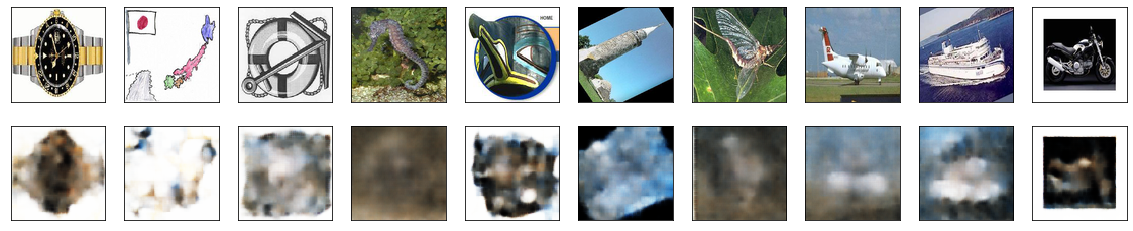

In [0]:
encoded_imgs = encoder_model.predict(x_test)
decoded_imgs = decoder_model.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(94, 94,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(94, 94,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()